In [1]:
# Install libraries
%pip install pandas nltk scikit-learn seaborn matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## import required basic libraries


In [2]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

## import our dataset

In [3]:
data=pd.read_csv("spam.csv",encoding="latin-1")
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [5]:
data.duplicated().sum()

np.int64(403)

In [6]:
# Show all duplicate rows
data[data.duplicated()]

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
102,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
153,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
206,ham,"As I entered my cabin my PA said, '' Happy B'd...",NaN,NaN,NaN
222,ham,"Sorry, I'll call later",NaN,NaN,NaN
325,ham,No calls..messages..missed calls,NaN,NaN,NaN
...,...,...,...,...,...
5524,spam,You are awarded a SiPix Digital Camera! call 0...,NaN,NaN,NaN
5535,ham,"I know you are thinkin malaria. But relax, chi...",NaN,NaN,NaN
5539,ham,Just sleeping..and surfing,NaN,NaN,NaN
5553,ham,Hahaha..use your brain dear,NaN,NaN,NaN


In [7]:
data = data.drop_duplicates()

In [8]:
# Check again to confirm
data.duplicated().sum()


np.int64(0)

### Remove columns which not add much values to our model and define our axis

In [9]:
data=data.drop(["Unnamed: 2","Unnamed: 3","Unnamed: 4"],axis=1)
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Wr are going to rename v1 and v2 to use them to classify spam or non spam

In [10]:
data=data.rename(columns={"v1":"label","v2":"message"})
data.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Now we will check is there any null value present in lebel or message column

In [11]:
data.isnull().sum()

label      0
message    0
dtype: int64

In [12]:
# Convert 'ham' to 0 and 'spam' to 1
data["label"] = data["label"].map({"ham": 0, "spam": 1})

## EDA (Exploraty data analysis)

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

### Check the distribution of ham and non spam ham or sopam catergory, so how many belong to the ham class and how many belong to the spam class

In [14]:
len(data[data["label"]=="ham"])

0

In [15]:
len(data[data["label"]=="spam"])

0

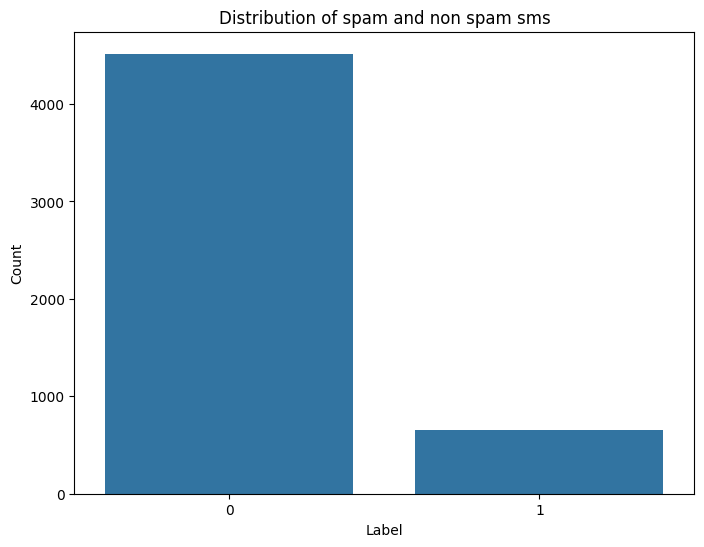

In [16]:
# Create a count plot to visualize the distribution of ham and spam messages
plt.figure(figsize=(8,6))
sns.countplot(x='label', data=data)
plt.title('Distribution of spam and non spam sms')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

### Let check how many characters present in the ham messages or how many characters present or length of characters in the spam

In [17]:
# apply length function to get the length of each message
data["sms_length"]=data["message"].apply(len)

In [18]:
data.head()

,label,message,sms_length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [19]:
# let see the first messages
data["message"][0]

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

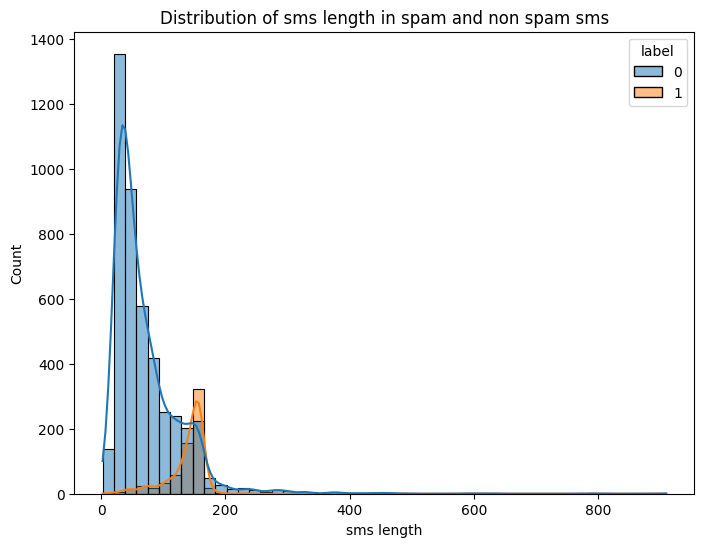

In [20]:
# let see which of them have the maximum length of characters
plt.figure(figsize=(8,6))
sns.histplot(x='sms_length', data=data, hue="label", bins=50, kde=True)
plt.title('Distribution of sms length in spam and non spam sms')
plt.xlabel('sms length')
plt.ylabel('Count')
plt.show()

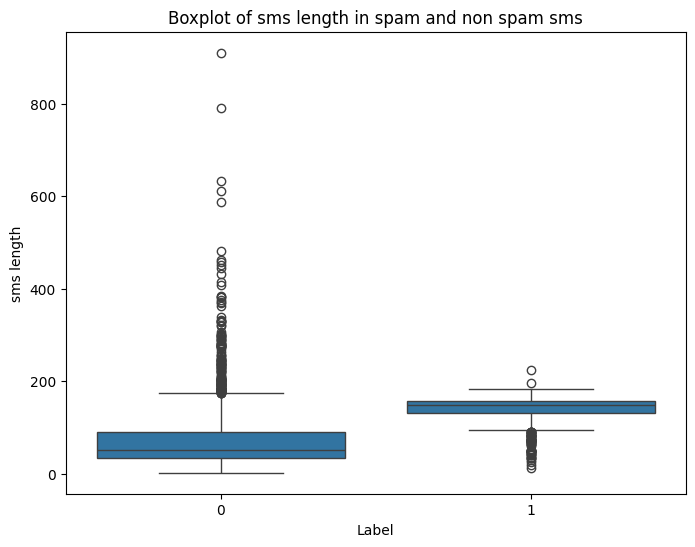

In [21]:
# we can check it also with boxplot
plt.figure(figsize=(8,6))
sns.boxplot(x='label', y='sms_length', data=data)
plt.title('Boxplot of sms length in spam and non spam sms')
plt.xlabel('Label')
plt.ylabel('sms length')
plt.show()

### Text Preprocessing
#### for text preprocessing we will remove the HTML tags if there any HTML tag present in our text message which is not good and not add any value to our model

In [22]:
# Define a function to remove HTML tags
import re # regular expressions
def remove_html_tags(text):
    clean_text = re.sub(r'<[^>]*>', '', text)
    return clean_text

data["message"]=data["message"].apply(remove_html_tags)


In [23]:
data.head()

,label,message,sms_length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


#### We are now going to tokenize our text 

In [24]:
import nltk
from nltk.tokenize import word_tokenize

In [25]:
nltk.download("punkt")
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\musta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\musta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [26]:
# tokenize the text
def tokenize_text(text):
    tokens = word_tokenize(text)
    return tokens
data["message"] = data["message"].apply(tokenize_text)

In [27]:
data.head()

,label,message,sms_length
0,0,"[Go, until, jurong, point, ,, crazy, .., Avail...",111
1,0,"[Ok, lar, ..., Joking, wif, u, oni, ...]",29
2,1,"[Free, entry, in, 2, a, wkly, comp, to, win, F...",155
3,0,"[U, dun, say, so, early, hor, ..., U, c, alrea...",49
4,0,"[Nah, I, do, n't, think, he, goes, to, usf, ,,...",61


In [28]:
data["label"].value_counts()

label
0    4516
1     653
Name: count, dtype: int64

In [29]:
# we can check the first message after conversion to tokens
data["message"][0]

['Go',
 'until',
 'jurong',
 'point',
 ',',
 'crazy',
 '..',
 'Available',
 'only',
 'in',
 'bugis',
 'n',
 'great',
 'world',
 'la',
 'e',
 'buffet',
 '...',
 'Cine',
 'there',
 'got',
 'amore',
 'wat',
 '...']

#### next we will removing the special characters in our tokens text like "," and ".." becuse they do not add any values

In [30]:
def remove_special_characters(tokens):
    clean_tokens = [word for word in tokens if word.isalnum() or word in ['$', '%']]
    return clean_tokens

data["message"] = data["message"].apply(remove_special_characters)

In [31]:
data["message"][0]

['Go',
 'until',
 'jurong',
 'point',
 'crazy',
 'Available',
 'only',
 'in',
 'bugis',
 'n',
 'great',
 'world',
 'la',
 'e',
 'buffet',
 'Cine',
 'there',
 'got',
 'amore',
 'wat']

#### next step is to removing stop words which also did not any value

In [32]:
import nltk
from nltk.corpus import stopwords

# Download the stopwords dataset
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\musta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [33]:
stopwords=set(stopwords.words("english"))

In [34]:
print(stopwords)

{'himself', 'on', 'hers', 'both', 'can', "we'd", "he'll", "wasn't", "i've", 'll', 'we', 'same', 'then', 'them', 'she', 'you', 'further', 've', "couldn't", "isn't", 'am', 'i', "weren't", 'if', 'against', 'and', 'who', "it'll", "mustn't", 'more', 'a', 'after', 'below', 'isn', 'd', 'own', "they're", 'in', 'him', 'nor', "it's", 'most', 't', 'needn', 'from', 'its', "you're", 'than', 'aren', 'as', 'their', 'shouldn', "mightn't", 'yours', 'not', 'all', 'was', 'when', "haven't", 'between', 'ain', 'at', 'once', 'shan', 'won', 'having', "it'd", 'where', 'for', 'mustn', 'o', 'into', 'how', 'with', 'up', 'through', 'any', 'only', "they'd", 'the', 'what', "i'd", "doesn't", 'haven', 're', 'is', 'does', 'no', 'which', "needn't", 'have', "you've", 'by', 'too', "i'll", "shan't", "we've", "don't", "hadn't", 'ma', 'under', 'again', 'they', 'so', 'that', "she'd", 'before', 'about', 'out', 'until', 'off', "he's", "they'll", 'your', 'here', 'he', "she's", 'were', 'wouldn', 'herself', "we'll", 'his', "wouldn

In [35]:
# define a function to remove stop words
def remove_stop_words(tokens):
    filtered_words = [word for word in tokens if word not in stopwords]
    return filtered_words

data["message"] = data["message"].apply(remove_stop_words)

In [36]:
# check if any stop words are remianing
stopword=[word for word in data["message"][39] if word in stopwords]
stopword

[]

#### next is staming which also an important step, we are going to to stam word like Killing, nothing or any other rude words giving in the message

In [37]:
st=PorterStemmer()

def stem_words(tokens):
    stemmed_words = [st.stem(word) for word in tokens]
    return stemmed_words

data["message"] = data["message"].apply(stem_words)


In [38]:
data.head()

,label,message,sms_length
0,0,"[go, jurong, point, crazi, avail, bugi, n, gre...",111
1,0,"[ok, lar, joke, wif, u, oni]",29
2,1,"[free, entri, 2, wkli, comp, win, fa, cup, fin...",155
3,0,"[u, dun, say, earli, hor, u, c, alreadi, say]",49
4,0,"[nah, i, think, goe, usf, live, around, though]",61


### build a model

In [39]:
# we are going to creating a clean message pass one by one message tokens to our model
# we have to combine this token message so far
data["message"] = data["message"].apply(lambda x: ' '.join(map(str, x)).lower())

In [40]:
# Now we can see our cleaned data
data["message"]

0       go jurong point crazi avail bugi n great world...
1                                   ok lar joke wif u oni
2       free entri 2 wkli comp win fa cup final tkt 21...
3                     u dun say earli hor u c alreadi say
4                  nah i think goe usf live around though
                              ...                        
5567    thi 2nd time tri 2 contact u pound prize 2 cla...
5568                           will b go esplanad fr home
5569                                 piti mood so suggest
5570    the guy bitch i act like interest buy someth e...
5571                                    rofl it true name
Name: message, Length: 5169, dtype: object

In [41]:
# we can see our tokens getting combined or joined so we have a clean message now
# It does not have any stop words or special characters and also stemmed words
data.head()

,label,message,sms_length
0,0,go jurong point crazi avail bugi n great world...,111
1,0,ok lar joke wif u oni,29
2,1,free entri 2 wkli comp win fa cup final tkt 21...,155
3,0,u dun say earli hor u c alreadi say,49
4,0,nah i think goe usf live around though,61


In [42]:
# lets print and display zero message
data["message"][0]

'go jurong point crazi avail bugi n great world la e buffet cine got amor wat'

### Now we will building model part

In [43]:
# we needs a librares to build our model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer # to convert text to numerical data

### Now we will split our data into a train and test part

In [44]:
x=data["message"]
y=data["label"]

### Convert our textual data into a numerical

In [45]:
vectorizer=TfidfVectorizer()
x=vectorizer.fit_transform(data["message"])
y=data["label"]


In [46]:
# Now we split our data into a train and test part 20% test and 80% train
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=40)

### Now we will train different models on our traning set and we will cheack accuracy on the testing set and then choose which has a high accuracy

In [47]:
# Support vector classifier
from sklearn.svm import SVC
svc_model=SVC()
svc_model.fit(x_train,y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [48]:
# Lets see the accuracy of our support vector classifier model
# lets perform model prediction
y_pred=svc_model.predict(x_test)
accuracy=accuracy_score(y_test,y_pred) # y_test are the true labels and y_pred are the predicted labels

print(f"accuracy_score: {accuracy}")

print(classification_report(y_test,y_pred))

accuracy_score: 0.9748549323017408
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       916
           1       1.00      0.78      0.88       118

    accuracy                           0.97      1034
   macro avg       0.99      0.89      0.93      1034
weighted avg       0.98      0.97      0.97      1034



### Lets move to another model that is Random Forest Classifier

In [49]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# create the model
rf_model=RandomForestClassifier(n_estimators=100, random_state=30)

rf_model.fit(x_train,y_train)



,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [50]:
# lets perform prediction on the test set
y_pred1= rf_model.predict(x_test)

accuracy=accuracy_score(y_test,y_pred1) # y_test are the true labels and y_pred are the predicted labels

print(f"accuracy_score: {accuracy}")

print(classification_report(y_test,y_pred1))

accuracy_score: 0.9738878143133463
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       916
           1       1.00      0.77      0.87       118

    accuracy                           0.97      1034
   macro avg       0.99      0.89      0.93      1034
weighted avg       0.97      0.97      0.97      1034



### Now lets compaire between them Accuracy 0.978 for Support Vector and 0.977 för Random Forest and checking as well Presision, Recall, F1.

## We can also build a Logistic Regression and test it

In [51]:
# build the logistic Regression
#from sklearn.linear_model import LogisticRegression

#lr_model=LogisticRegression() # create the model
#lr_model.fit(x_train,y_train)

## Implement Logistic Regression from scratch

In [54]:
# Logistic Regression from Scratch

import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


class LogisticRegressionScratch:
    def __init__(self, lr=0.001, n_iters=1000):
        self.lr = lr
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        if hasattr(X, "toarray"):
            X = X.toarray()
    
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Gradient Descent
        for _ in range(self.n_iters):
            linear_pred = np.dot(X, self.weights) + self.bias
            predictions = sigmoid(linear_pred)

            # Gradients
            dw = (1 / n_samples) * np.dot(X.T, (predictions - y))
            db = (1 / n_samples) * np.sum(predictions - y)

            # Update weights
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        if hasattr(X, "toarray"):
            X = X.toarray()
        linear_pred = np.dot(X, self.weights) + self.bias
        y_pred = sigmoid(linear_pred)
        class_pred = [0 if y<=0.5 else 1 for y in y_pred]
        return class_pred


In [57]:
### Now our model is ready for prediction
# # Train & Evaluate

from sklearn.metrics import accuracy_score, classification_report

lr_model = LogisticRegressionScratch(lr=1.0, n_iters=3000)
lr_model.fit(x_train, y_train)
y_pred_scratch = lr_model.predict(x_test)

print("_ Logistic Regression (Scratch) Results _")
print("Accuracy:", accuracy_score(y_test, y_pred_scratch))
print("\nClassification Report:\n", classification_report(y_test, y_pred_scratch))


_ Logistic Regression (Scratch) Results _
Accuracy: 0.9622823984526112

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       916
           1       0.96      0.69      0.81       118

    accuracy                           0.96      1034
   macro avg       0.96      0.85      0.89      1034
weighted avg       0.96      0.96      0.96      1034



### Now our model is ready for prediction

### We can see the accuracy score is 0.96 and F1 for class 0 is 0.98,and also class 1 it is lower compared to the Random Forest and Support Vector Classifier

## We chosed the one of these three and we will use, and it is the Logistic Regression as our final model

In [ ]:
# Save the Loistic Regression Scratch model
import numpy as np
import pickle


with open("lr_model_scratch.pkl", "wb") as model_file:
    pickle.dump(lr_model, model_file)
    
# Save the TfidVectorizer this is for deployment
with open("tfidf_vectorizer_lr.pkl", "wb") as model_file:
    pickle.dump(vectorizer, model_file)

In [ ]:
### Now save Random Forest with a help of pickle
#import pickle
#with open("rf_model.pkl", "wb") as model_file:
    #pickle.dump(rf_model,model_file)

In [ ]:
#with open("tfidf_vectorizer.pkl", "wb") as model_file:
    #pickle.dump(vectorizer, model_file)

### Nest step is create a file names spam_classify.py to build our API endpoint build a flask app as a backend so we should to go to the this file and import some libraries